### Домашнее задание 3 по компьютерному зрению
Выполнил Партин Максим

Проверил Копылов Иван

### Классификация объектов на изображении

In [15]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import random
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import polars as pl
import shutil
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Установка значений всевозможных генераторов случайных чисел в seed 42 для воссоздания эскперимента
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
generator = torch.Generator().manual_seed(42)

os.makedirs("sample_data", exist_ok=True)
os.makedirs("simpsons_dataset", exist_ok=True)

Скачививание и распаковка архива с датасетом

In [2]:
!gdown https://drive.google.com/drive/folders/10-7GyM-RQklcncnLIrvp3jwb4VUrOv3J --folder

Retrieving folder contents
Processing file 1JKU-TCssTiAa6CUIz3GcoREQQKi0rPlL simpsons_dataset.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1JKU-TCssTiAa6CUIz3GcoREQQKi0rPlL
From (redirected): https://drive.google.com/uc?id=1JKU-TCssTiAa6CUIz3GcoREQQKi0rPlL&confirm=t&uuid=af97c4d3-3e1d-411e-8ad3-9851de3cb5b0
To: /home/student/partin/hse_cv/hw3/simpsons_dataset/simpsons_dataset.zip
100%|████████████████████████████████████████| 535M/535M [00:07<00:00, 73.7MB/s]
Download completed


In [9]:
!unzip -q simpsons_dataset/simpsons_dataset.zip -d sample_data

caution: filename not matched:  -y


В качестве датасета был взят датасет с персонажами из сериала симпсоны. Задача классифицировать симпсона по фотографии с ним. Датасет имеет следующую структуру

```
└── simpsons_dataset/
    └── <simpson_name>/
        └── *.jpg
```

Где simpson_name - название персонажа из симпсонов, *.jpg - фотографии с данным персонажем

Посмотрим на размер изображений в датасет, чтобы понять они одинаковые все или нет

In [10]:
image_sizes = {}
path_to_dataset = "sample_data/simpsons_dataset"
simpson_names = os.listdir(path_to_dataset)

for simpson_name in simpson_names:
  path_to_simpson_images = os.path.join(path_to_dataset, simpson_name)
  images_with_simpson = os.listdir(path_to_simpson_images)
  for image_with_simpson in images_with_simpson:
    path_to_simpson_image = os.path.join(path_to_simpson_images, image_with_simpson)
    simpson_image_size = Image.open(path_to_simpson_image).size
    if simpson_image_size not in image_sizes:
      image_sizes[simpson_image_size] = 0
    image_sizes[simpson_image_size] += 1

list(image_sizes.items())[:5]

[((288, 416), 1715),
 ((320, 480), 3005),
 ((640, 480), 2158),
 ((288, 432), 2931),
 ((320, 464), 472)]

Видим размеры изображений различаются. Придется делать resize каждого изображения для обучения сети. Будем ресайзить все к 224 на 224 размер изображений сети resnet. Теперь разделим датасет на тренирочную, валидационную и тестовую выборки

In [11]:
simpson_images = {
    "simpson_name": [],
    "path_to_simpson_image": [],
}
for simpson_name in simpson_names:
  path_to_simpson_images = os.path.join(path_to_dataset, simpson_name)
  images_with_simpson = os.listdir(path_to_simpson_images)
  for image_with_simpson in images_with_simpson:
    path_to_simpson_image = os.path.join(path_to_simpson_images, image_with_simpson)
    simpson_images["simpson_name"].append(simpson_name)
    simpson_images["path_to_simpson_image"].append(path_to_simpson_image)
simpson_images = pl.DataFrame(simpson_images)
simpson_images.select("*").limit()

shape: (5, 2)
┌──────────────┬─────────────────────────────────┐
│ simpson_name ┆ path_to_simpson_image           │
│ ---          ┆ ---                             │
│ str          ┆ str                             │
╞══════════════╪═════════════════════════════════╡
│ lisa_simpson ┆ sample_data/simpsons_dataset/l… │
│ lisa_simpson ┆ sample_data/simpsons_dataset/l… │
│ lisa_simpson ┆ sample_data/simpsons_dataset/l… │
│ lisa_simpson ┆ sample_data/simpsons_dataset/l… │
│ lisa_simpson ┆ sample_data/simpsons_dataset/l… │
└──────────────┴─────────────────────────────────┘

In [12]:
# Для того, чтобы каждый из симсонов попал и в train, val, test итерируемся по ним отдельно
TRAIN_FOLDER, VAL_FOLDER, TEST_FOLDER = "train", "val", "test"

# Функция для сохранения изображения в назначенную директорию
def save_images(simpson_images_df: pl.DataFrame, folder_name: str):
  for image_idx, row in enumerate(simpson_images_df.iter_rows(named=True)):
    simpson_name, path_to_simpson_image = row["simpson_name"], row["path_to_simpson_image"]
    path_to_simpson_folder = os.path.join(folder_name, simpson_name)
    os.makedirs(path_to_simpson_folder, exist_ok=True)
    shutil.copy(path_to_simpson_image, os.path.join(path_to_simpson_folder, f"{simpson_name}_{image_idx}.jpg"))

for simpson_name in simpson_names:
  simpson_images_cur_simpson = simpson_images.filter(pl.col("simpson_name") == simpson_name)
  simpson_images_cur_train, simpson_images_cur_temp = train_test_split(simpson_images, test_size=0.4, random_state=seed)
  simspon_images_cur_val, simspon_images_cur_test = train_test_split(simpson_images_cur_temp, test_size=0.5, random_state=seed)
  save_images(simpson_images_cur_train, TRAIN_FOLDER)
  save_images(simspon_images_cur_val, VAL_FOLDER)
  save_images(simspon_images_cur_test, TEST_FOLDER)

In [13]:
simpson_names

['lisa_simpson',
 'cletus_spuckler',
 'principal_skinner',
 'nelson_muntz',
 'rainier_wolfcastle',
 'carl_carlson',
 'charles_montgomery_burns',
 'agnes_skinner',
 'milhouse_van_houten',
 'barney_gumble',
 'martin_prince',
 'maggie_simpson',
 'sideshow_bob',
 'bart_simpson',
 'snake_jailbird',
 'marge_simpson',
 'troy_mcclure',
 'gil',
 'apu_nahasapeemapetilon',
 'groundskeeper_willie',
 'fat_tony',
 'patty_bouvier',
 'selma_bouvier',
 'kent_brockman',
 'lenny_leonard',
 'homer_simpson',
 'edna_krabappel',
 'professor_john_frink',
 'disco_stu',
 'waylon_smithers',
 'miss_hoover',
 'ned_flanders',
 'abraham_grampa_simpson',
 'krusty_the_clown',
 'mayor_quimby',
 'comic_book_guy',
 'ralph_wiggum',
 'sideshow_mel',
 'lionel_hutz',
 'otto_mann',
 'moe_szyslak',
 'chief_wiggum']

Создадим кастомный класс датасета для загрузки и чтения датасета

In [14]:
class SimpsonDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir: str, label_to_idx: dict[str, int], transform = None):
    simpson_names = os.listdir(data_dir)
    self.simpsons_image_paths = []
    self.labels = []
    self.transform = transform
    for simpson_name in simpson_names:
      path_to_simpson_images = os.path.join(data_dir, simpson_name)
      simpson_images = os.listdir(path_to_simpson_images)
      for simpson_image in simpson_images:
        self.simpsons_image_paths.append(os.path.join(path_to_simpson_images, simpson_image))
        self.labels.append(label_to_idx[simpson_name])


  def __len__(self) -> int:
    return len(self.simpsons_image_paths)


  def __getitem__(self, index: int):
    path_to_simpson_image = self.simpsons_image_paths[index]
    label = self.labels[index]
    image = Image.open(path_to_simpson_image)
    if self.transform:
      image = self.transform(image)
    return image, torch.tensor(label)

Обучим LabelEncoder для того, чтобы переводить лейблы из текста в число и обратно

In [15]:
le = LabelEncoder()
le.fit(simpson_names)
le.classes_

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

In [16]:
label_to_idx = {simpson_name: le.transform([simpson_name])[0] for simpson_name in simpson_names}
idx_to_label = {idx: simpson_name for simpson_name, idx in label_to_idx.items()}

загрузим изображения в датасет и применим трансформации

In [17]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
train_dataset = SimpsonDataset(TRAIN_FOLDER, label_to_idx, transform)
val_dataset = SimpsonDataset(VAL_FOLDER, label_to_idx, transform)
test_dataset = SimpsonDataset(TEST_FOLDER, label_to_idx, transform)

In [18]:
print(f"Количество изображений в датасете: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

Количество изображений в датасете: 20933


Разделим датасет на train, val, test

Посмотрим на изображения в датасете

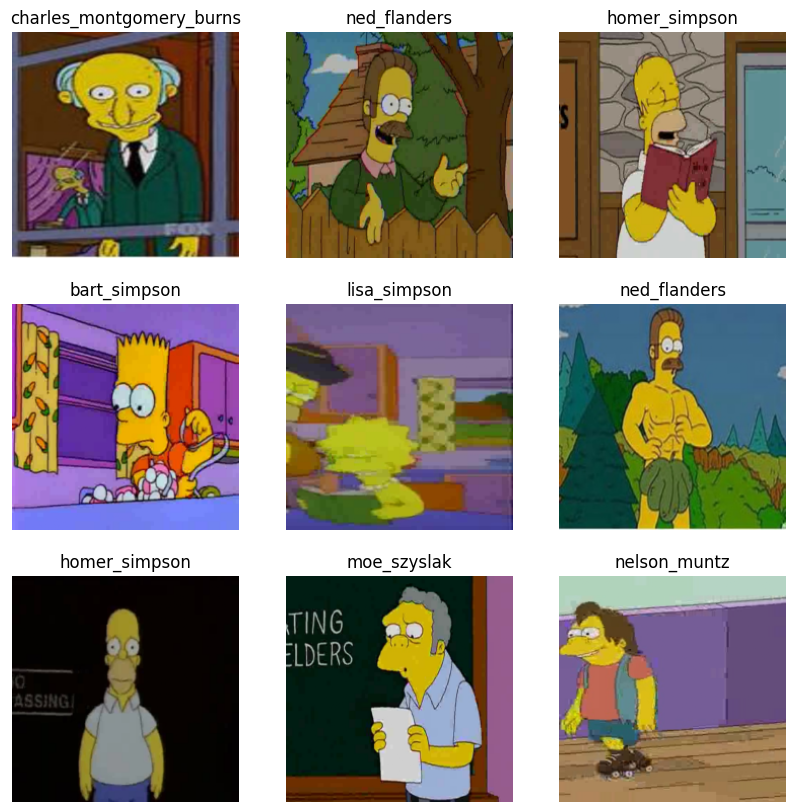

In [19]:
random_indexes = np.random.choice(np.arange(len(train_dataset)), size=9, replace=False)
_, axes = plt.subplots(3, 3, figsize=(10, 10))
random_indexes = random_indexes.reshape((3, 3))
for i in range(3):
  for j in range(3):
    image_index = random_indexes[i][j]
    axes[i][j].imshow(train_dataset[image_index][0].permute(1, 2, 0).numpy())
    class_name = le.inverse_transform([train_dataset[image_index][1]])[0]
    axes[i][j].set_title(class_name)
    axes[i][j].axis("off")
plt.axis("off")
plt.show()

Посчитаем значение среднего и дисперсии на тренировочной части датасета для изображений

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=False, batch_size=64) # В данном случае не нужно шафлить, так как еще не обучаем сеть

mean = torch.Tensor([0.0, 0.0, 0.0])
std = torch.Tensor([0.0, 0.0, 0.0])
for images, _ in train_dataloader:
  batch_size = images.size(0)
  images = images.view(batch_size, images.size(1), -1)
  mean += images.mean(2).sum(0)
  std += images.std(2).sum(0)

mean = mean / len(train_dataloader.dataset)
std = std / len(train_dataloader.dataset)
mean, std = mean.cpu().numpy(), std.cpu().numpy()
print(f"mean: {mean}, std: {std}")

mean: [0.46238256 0.40879723 0.35345754], std: [0.2124368  0.1911674  0.22055912]


Определим модель Resnet и обучим ее, пока без аугментации

#### Первый эксперимент Resnet без аугментации 5 эпох

Функция потерь - Adam

In [21]:
from tqdm import tqdm

def train_model(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int, train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset, batch_size: int, experiment_name: str, device: str) -> tuple[nn.Module, list[float], list[float]]:
  best_val_loss = float("inf")
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  train_epoch_losses = []
  val_epoch_losses = []
  for epoch in tqdm(range(num_epochs), desc="Epoch"):
    print(f"Epoch: {epoch}")

    # Цикл обучения по обучающей выборке из датасета
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_epoch_losses.append(epoch_loss)

    # Прогон модели по валидационной выборке
    model.eval()
    val_running_loss = 0.0

    for inputs, labels in tqdm(val_loader, desc="Validation"):
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad():
          outputs = model(inputs)
          loss = criterion(outputs, labels)

      val_running_loss += loss.item() * inputs.size(0)

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_losses.append(val_epoch_loss)

    if val_epoch_loss < best_val_loss:
      print(f"New best model on epoch: {epoch}")
      best_val_loss = val_epoch_loss
      torch.save(model.state_dict(), f"{experiment_name}_best_model.pth")

    print(f"Train loss: {epoch_loss:.4f}, Val loss: {val_epoch_loss:.4f}")
  return model, train_epoch_losses, val_epoch_losses

In [22]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
          (0.4626, 0.4086, 0.3532),
          (0.2124, 0.1912, 0.2208),
        ),
    ]
)
train_dataset = SimpsonDataset(TRAIN_FOLDER, label_to_idx, transform)
val_dataset = SimpsonDataset(VAL_FOLDER, label_to_idx, transform)
test_dataset = SimpsonDataset(TEST_FOLDER, label_to_idx, transform)

model = models.resnet50(models.ResNet50_Weights)
model

/home/student/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/student/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
%%time

# Замораживаем все слои
for param in model.parameters():
    param.requires_grad = False

# Выходной слой оставляем не замороженным
model.fc = nn.Linear(in_features=2048, out_features=len(simpson_names))

# Обучаем модель
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5
batch_size = 512
experiment_name = "resnet_50_on_5_epochs_freeze_weights_instead_linear"

model, train_losses, val_losses = train_model(model, criterion, optimizer, num_epochs, train_dataset, val_dataset, batch_size, experiment_name=experiment_name, device=device)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0



Epoch:  20%|██        | 1/5 [01:03<04:14, 63.51s/it]

New best model on epoch: 0
Train loss: 2.8298, Val loss: 2.2766
Epoch: 1



Epoch:  40%|████      | 2/5 [02:00<02:59, 59.79s/it]

New best model on epoch: 1
Train loss: 1.9895, Val loss: 1.7487
Epoch: 2



Epoch:  60%|██████    | 3/5 [02:57<01:56, 58.35s/it]

New best model on epoch: 2
Train loss: 1.5775, Val loss: 1.4851
Epoch: 3



Epoch:  80%|████████  | 4/5 [03:51<00:56, 56.85s/it]

New best model on epoch: 3
Train loss: 1.3498, Val loss: 1.3165
Epoch: 4



Epoch: 100%|██████████| 5/5 [04:47<00:00, 57.58s/it]

New best model on epoch: 4
Train loss: 1.2018, Val loss: 1.2178
CPU times: user 1h 56min 35s, sys: 35.3 s, total: 1h 57min 10s
Wall time: 4min 48s


Построим график функций потерь на тренировочной и валиадиационной выборках

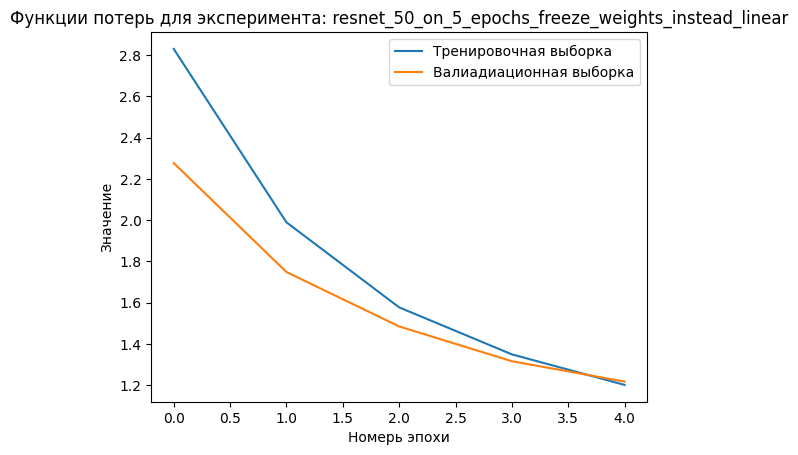

In [24]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Тренировочная выборка")
plt.plot(np.arange(len(val_losses)), val_losses, label="Валиадиационная выборка")
plt.title(f"Функции потерь для эксперимента: {experiment_name}")
plt.xlabel("Номерь эпохи")
plt.ylabel("Значение")
plt.legend()
plt.show()

**Вывод:** Нейросеть обучилась, возможно не до конца стоит еще поставить на несколько эпох

Напишем функцию для получения предсказаний модели и для расчета метрик качества

In [25]:
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score

# Функция для получения предсказаний модели
def make_predictions(model: nn.Module, data_loader: torch.utils.data.DataLoader, device: str) -> tuple[np.ndarray, np.ndarray]:
  model.eval()
  predicted_labels = []
  predicted_label_probas = []
  for images, _ in data_loader:
    images = images.to(device)
    with torch.no_grad():
      outputs = model(images)
      predicted_labels.extend(F.softmax(outputs, dim=-1).argmax(axis=1).cpu().numpy())
      predicted_label_probas.extend(F.softmax(outputs, dim=-1).max(axis=1).values.cpu().numpy())

  return np.array(predicted_labels), np.array(predicted_label_probas)

# Функция для расчета метрик качества модели
def compute_metrics(model: nn.Module, data_loader: torch.utils.data.Dataset, experiment_name: str, print_metrics: bool = False) -> dict:
  predicted_labels, _ = make_predictions(model, data_loader, device)
  true_labels = []
  for _, labels in data_loader:
    true_labels.extend(labels.cpu().numpy())
  true_labels = np.array(true_labels)
  metrics = {
      "f1": f1_score(true_labels, predicted_labels, average="macro"),
      "recall": recall_score(true_labels, predicted_labels, average="macro"),
      "precision": recall_score(true_labels, predicted_labels, average="macro"),
  }
  if print_metrics:
    print(f"Experiment name: {experiment_name}")
    print(f"model_metrics: {metrics}")
  return metrics

In [26]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
metrics = compute_metrics(model, test_loader, experiment_name, print_metrics=True)

Experiment name: resnet_50_on_5_epochs_freeze_weights_instead_linear
model_metrics: {'f1': 0.3739822799177508, 'recall': 0.3573052961799968, 'precision': 0.3573052961799968}


Получили метрики для первого эксперимента, сделаем пометку, а сейчас визуализируем предсказания модели

In [27]:
def visualize_model_predictions(model: nn.Module, test_dataset: torch.utils.data.Dataset,
                                test_loader: torch.utils.data.Dataset, experiment_name: str,
                                device: str, le: LabelEncoder, mean: np.ndarray | None = None, std: np.ndarray | None = None):
  predicted_labels, predicted_probas = make_predictions(model, test_loader, device)
  true_labels = []
  for _, labels in test_loader:
    true_labels.extend(labels.cpu().numpy())
  true_labels = np.array(true_labels)
  random_indexes = np.random.choice(np.arange(len(test_dataset)), size=9, replace=False)
  _, axes = plt.subplots(3, 3, figsize=(15, 15))
  random_indexes = random_indexes.reshape((3, 3))
  plt.title(experiment_name)
  for i in range(3):
    for j in range(3):
      image_index = random_indexes[i][j]
      image = test_dataset[image_index][0].permute(1, 2, 0).numpy()
      if mean is not None and std is not None:
        image = image * mean + std
        image = np.clip(image, 0, 1)
      axes[i][j].imshow(image)
      true_class_name = le.inverse_transform([test_dataset[image_index][1]])[0]
      predicted_class_name = le.inverse_transform([predicted_labels[image_index]])[0]
      predicted_proba = predicted_probas[image_index]
      axes[i][j].set_title(f"true_class_name: {true_class_name} \n predicted_class_name: {predicted_class_name} \n proba: {predicted_proba}")
      axes[i][j].axis("off")
  plt.axis("off")
  plt.show()

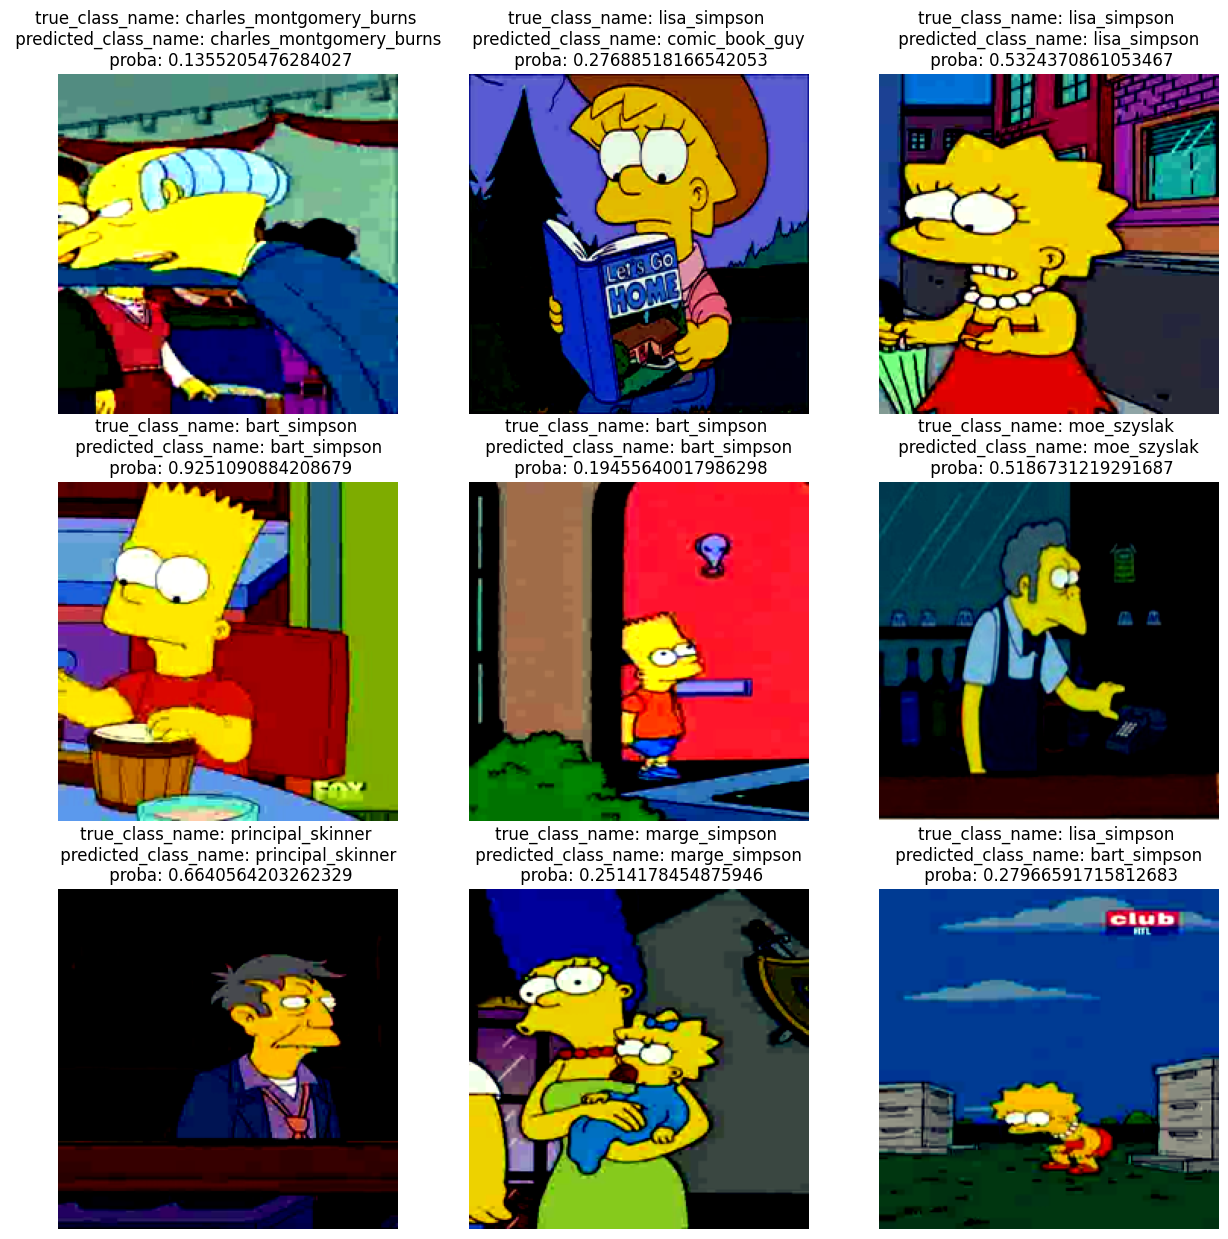

In [28]:
visualize_model_predictions(model, test_dataset, test_loader, experiment_name, device, le, mean, std)

Эксперимент 2 пробуем обучить resnet50 при этом добавить аугментации к тренировочной и тестовой частям. Обучение займет 10 эпох

In [39]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomRotation(30), # Случайно поворачиваем изображение на +- 30 градусов во время обучения
        transforms.RandomGrayscale(p=0.1), # Случайно переводим изображение в оттенки серого с вероятностью 0.1 во время обучения
        transforms.ColorJitter( # Случайно изменяем цветовую палитру изображения во время обучения
          brightness=0.2,
          contrast=0.2,
          saturation=0.2,
          hue=0.1
        ),
        transforms.ToTensor(),
        transforms.Normalize(
          (0.4626, 0.4086, 0.3532),
          (0.2124, 0.1912, 0.2208),
        ),
    ]
)

val_and_test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
          (0.4626, 0.4086, 0.3532),
          (0.2124, 0.1912, 0.2208),
        ),
    ]
)

train_dataset = SimpsonDataset(TRAIN_FOLDER, label_to_idx, train_transform)
val_dataset = SimpsonDataset(VAL_FOLDER, label_to_idx, val_and_test_transform)
test_dataset = SimpsonDataset(TEST_FOLDER, label_to_idx, val_and_test_transform)
model = models.resnet50(models.ResNet50_Weights)
for param in model.parameters():
    param.requires_grad = False
# Выходной слой оставляем не замороженным
model.fc = nn.Linear(in_features=2048, out_features=len(simpson_names))
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 10
batch_size = 128
experiment_name = "resnet_50_on_10_epochs_and_data_augmentations"
model, train_losses, val_losses = train_model(model, criterion, optimizer, num_epochs, train_dataset, val_dataset, batch_size, experiment_name=experiment_name, device=device)

/home/student/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/student/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0



Epoch:  10%|█         | 1/10 [01:41<15:09, 101.04s/it]

New best model on epoch: 0
Train loss: 2.6091, Val loss: 2.1207
Epoch: 1



Epoch:  20%|██        | 2/10 [03:15<12:56, 97.11s/it] 

New best model on epoch: 1
Train loss: 1.9631, Val loss: 1.8035
Epoch: 2



Epoch:  30%|███       | 3/10 [04:50<11:13, 96.21s/it]

New best model on epoch: 2
Train loss: 1.7371, Val loss: 1.6637
Epoch: 3



Epoch:  40%|████      | 4/10 [06:25<09:34, 95.70s/it]

New best model on epoch: 3
Train loss: 1.6035, Val loss: 1.5327
Epoch: 4



Epoch:  50%|█████     | 5/10 [08:00<07:56, 95.29s/it]

New best model on epoch: 4
Train loss: 1.5232, Val loss: 1.4865
Epoch: 5



Epoch:  60%|██████    | 6/10 [09:34<06:20, 95.07s/it]

New best model on epoch: 5
Train loss: 1.4629, Val loss: 1.4530
Epoch: 6



Epoch:  70%|███████   | 7/10 [11:09<04:45, 95.12s/it]

New best model on epoch: 6
Train loss: 1.4300, Val loss: 1.3897
Epoch: 7



Epoch:  80%|████████  | 8/10 [12:44<03:09, 94.84s/it]

New best model on epoch: 7
Train loss: 1.3657, Val loss: 1.3855
Epoch: 8



Epoch:  90%|█████████ | 9/10 [14:19<01:34, 94.87s/it]

New best model on epoch: 8
Train loss: 1.3350, Val loss: 1.3607
Epoch: 9



Epoch: 100%|██████████| 10/10 [15:53<00:00, 95.38s/it]

Train loss: 1.3140, Val loss: 1.3700


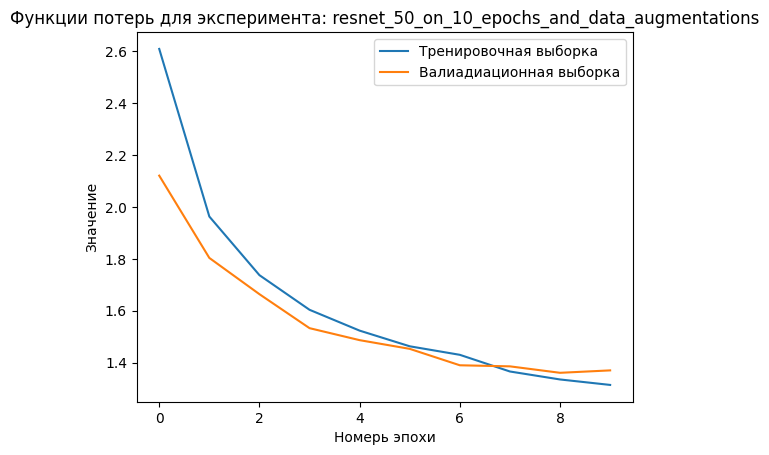

In [40]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Тренировочная выборка")
plt.plot(np.arange(len(val_losses)), val_losses, label="Валиадиационная выборка")
plt.title(f"Функции потерь для эксперимента: {experiment_name}")
plt.xlabel("Номерь эпохи")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [41]:
metrics = compute_metrics(model, test_loader, experiment_name, print_metrics=True)

Experiment name: resnet_50_on_10_epochs_and_data_augmentations
model_metrics: {'f1': 0.385164304420574, 'recall': 0.3618351207423891, 'precision': 0.3618351207423891}


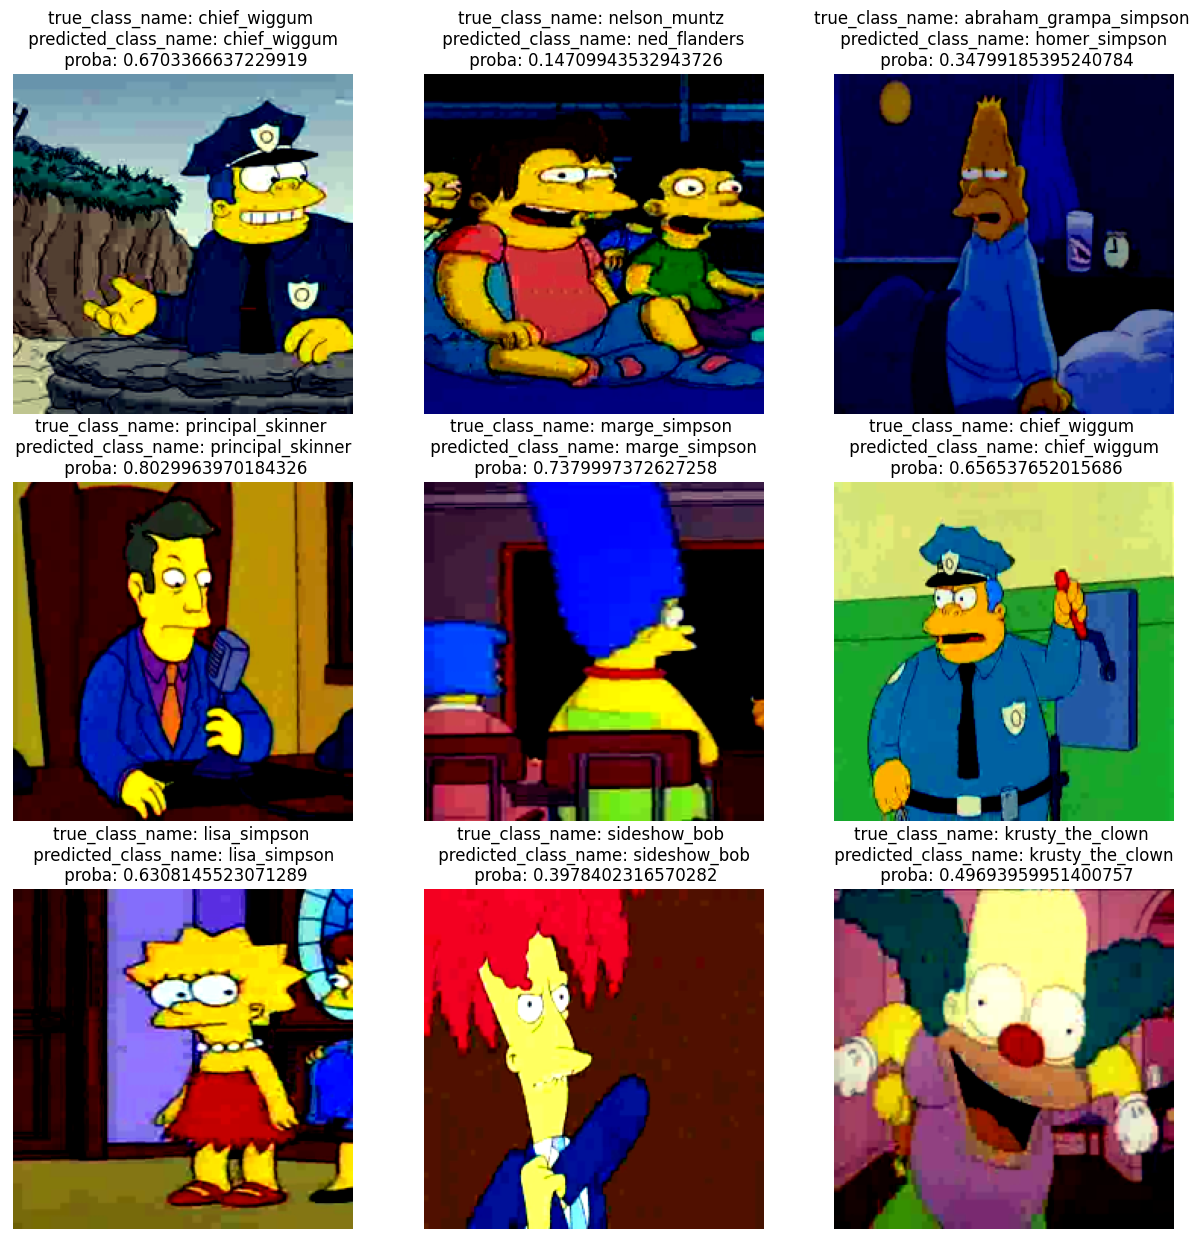

In [42]:
visualize_model_predictions(model, test_dataset, test_loader, experiment_name, device, le, mean, std)

Эксперимент 3 пробуем обучить EfficientNet на данном датасете

In [33]:
model = models.efficientnet_b0(models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [35]:
%%time

# Замораживаем все слои
for param in model.parameters():
    param.requires_grad = False

# Выходной слой оставляем не замороженным
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(simpson_names)),
)

# Обучаем модель
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5
batch_size = 512
experiment_name = "efficient_net_b0_on_5_epochs_freeze_weights_instead_linear"

model, train_losses, val_losses = train_model(model, criterion, optimizer, num_epochs, train_dataset, val_dataset, batch_size, experiment_name=experiment_name, device=device)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0



Epoch:  20%|██        | 1/5 [00:51<03:26, 51.62s/it]

New best model on epoch: 0
Train loss: 2.9794, Val loss: 2.4824
Epoch: 1



Epoch:  40%|████      | 2/5 [01:47<02:41, 53.91s/it]

New best model on epoch: 1
Train loss: 2.2923, Val loss: 2.0076
Epoch: 2



Epoch:  60%|██████    | 3/5 [02:42<01:48, 54.42s/it]

New best model on epoch: 2
Train loss: 1.9110, Val loss: 1.7243
Epoch: 3



Epoch:  80%|████████  | 4/5 [03:36<00:54, 54.53s/it]

New best model on epoch: 3
Train loss: 1.6753, Val loss: 1.5503
Epoch: 4



Epoch: 100%|██████████| 5/5 [04:30<00:00, 54.07s/it]

New best model on epoch: 4
Train loss: 1.5092, Val loss: 1.4237
CPU times: user 1h 51min 22s, sys: 29.6 s, total: 1h 51min 52s
Wall time: 4min 30s


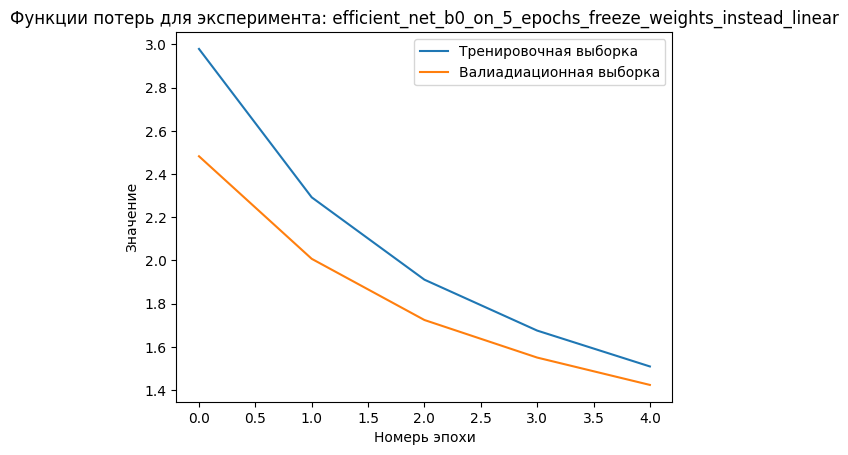

In [36]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Тренировочная выборка")
plt.plot(np.arange(len(val_losses)), val_losses, label="Валиадиационная выборка")
plt.title(f"Функции потерь для эксперимента: {experiment_name}")
plt.xlabel("Номерь эпохи")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [37]:
metrics = compute_metrics(model, test_loader, experiment_name, print_metrics=True)

Experiment name: efficient_net_b0_on_5_epochs_freeze_weights_instead_linear
model_metrics: {'f1': 0.34099228676243, 'recall': 0.3267044041781067, 'precision': 0.3267044041781067}


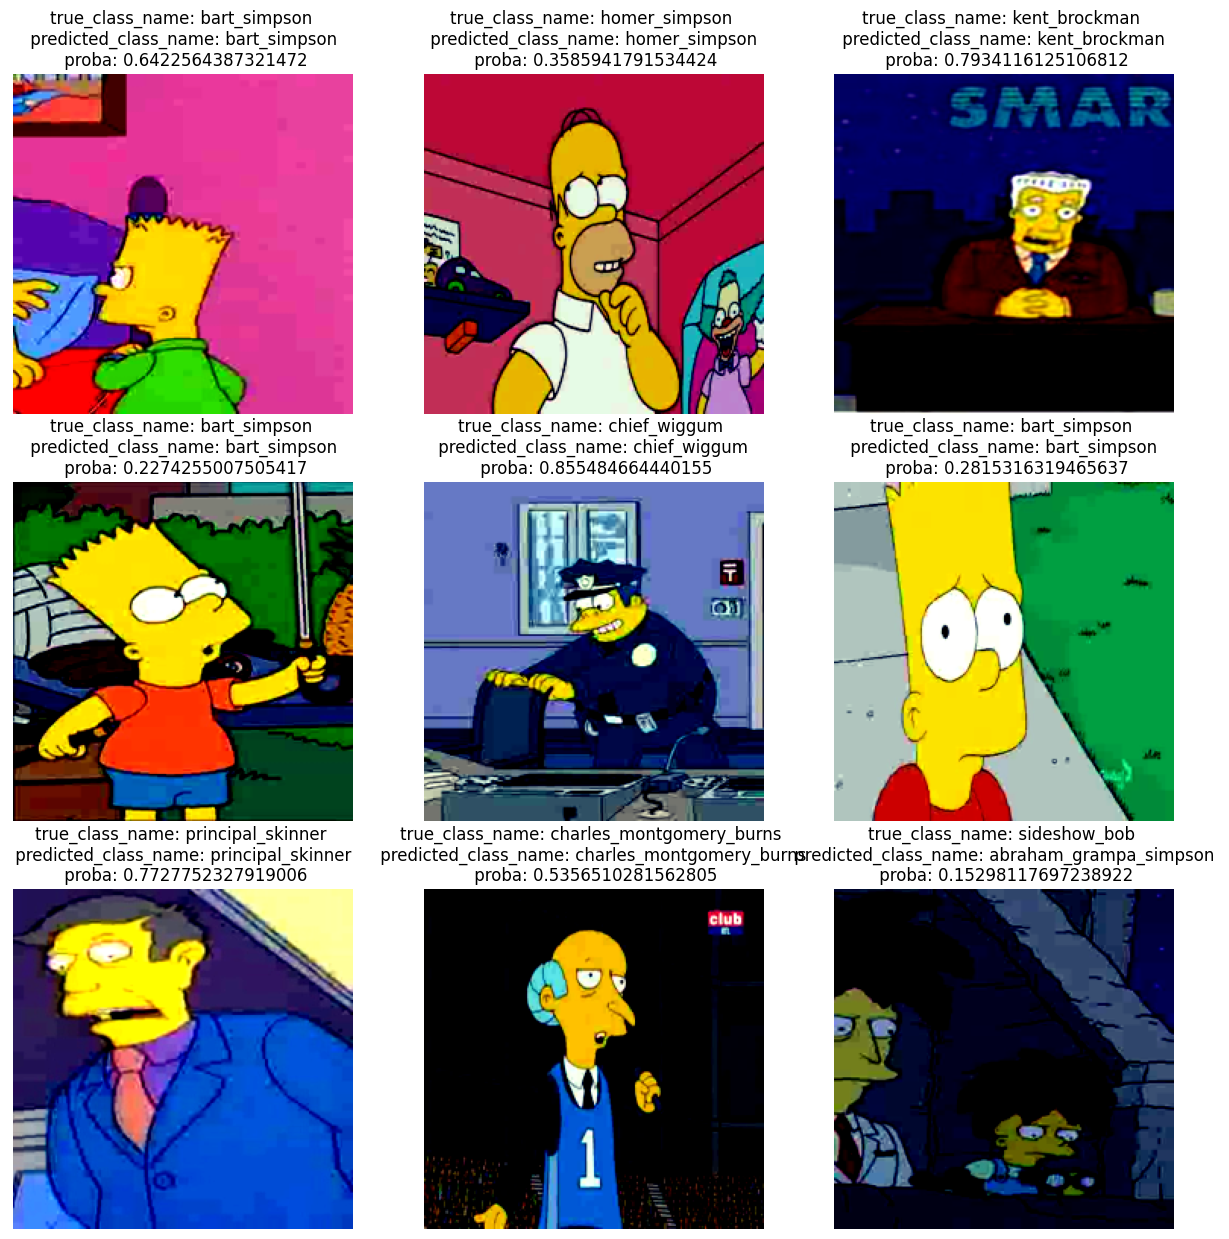

In [38]:
visualize_model_predictions(model, test_dataset, test_loader, experiment_name, device, le, mean, std)

**Вывод:** В результате трех проведенных экспериментов с моделями. Наилучшим оказался resnet_50 с аугментациями, обученный 10 эпох.

### Обучение детектора на изображениях

In [43]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 130.2 MB/s eta 0:00:00a 0:00:01


В качестве датасета был взят датасет с сайта roboflow https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc. По детектированию
игроков в футбол. Датасет имеет 4 класса: футбольный мяч, игрок на поле, вратарь и судья. Задача задетектировать тип объекта по фотографии со стадиона

In [53]:
!unzip -q football_players.zip -d football_players

In [55]:
!ls football_players

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [1]:
from ultralytics import YOLO
import warnings
warnings.filterwarnings("ignore")

model = YOLO("yolo12n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(
    data="football_players/data.yaml", 
    epochs=100, 
    imgsz=(1920, 1080),
    batch=8,
    device=0, 
    workers=4,
    optimizer='auto',
    lr0=0.01,
    name='yolo12_1080p'
)

Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.7.1+cu126 CUDA:0 (NVIDIA A100 80GB PCIe, 81154MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=football_players/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(1920, 1080), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_1080p, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

train: Scanning /home/student/partin/hse_cv/hw3/football_players/train/labels.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2129.1±1459.5 MB/s, size: 218.3 KB)


val: Scanning /home/student/partin/hse_cv/hw3/football_players/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]


Plotting labels to /home/student/partin/wildfire_detection/runs/detect/yolov8_1080p/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 1920 train, 1920 val
Using 4 dataloader workers
Logging results to /home/student/partin/wildfire_detection/runs/detect/yolov8_1080p
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      52.7G     0.9866      2.608     0.8971         93       1920: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

                   all         43       1025     0.0674      0.338      0.139     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      52.6G     0.9548      1.457     0.8976         76       1920: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         43       1025     0.0971      0.394      0.235       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      52.4G     0.9628      1.349     0.8967        103       1920: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         43       1025       0.73      0.201      0.252      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      52.5G     0.9412      1.292     0.9001        143       1920: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         43       1025      0.718      0.295      0.262      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      52.7G      0.882      1.218     0.8868         90       1920: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         43       1025      0.975      0.237      0.299      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      52.6G     0.8506      1.154     0.8719        127       1920: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


                   all         43       1025      0.473      0.291      0.315      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      52.8G     0.8526        1.1     0.8784         62       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         43       1025      0.532      0.439      0.442      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      52.4G     0.8289      1.031     0.8662        134       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         43       1025      0.662      0.486      0.528       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      52.2G     0.7937     0.9628     0.8653         95       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         43       1025      0.598      0.523      0.573      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      52.8G     0.8405     0.9268     0.8621        139       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

                   all         43       1025      0.672      0.686      0.683      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      52.6G      0.849     0.9185      0.874         63       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         43       1025      0.716      0.667      0.722       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      51.8G     0.8574     0.9135     0.8694        117       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         43       1025      0.646      0.677      0.639      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      52.8G     0.8309     0.8616     0.8642         72       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         43       1025       0.81      0.684      0.708      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      52.7G      0.786     0.8213     0.8679         88       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         43       1025       0.88       0.67      0.765      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100        52G     0.7799     0.7791     0.8578         99       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         43       1025      0.925      0.701      0.773      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      52.7G     0.8011     0.7507     0.8583         46       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         43       1025      0.895      0.659       0.74      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      52.1G     0.8498     0.7393     0.8646         68       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         43       1025      0.895      0.689      0.776      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      52.5G     0.8199     0.7213      0.867         54       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         43       1025      0.881      0.786      0.818      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      52.9G     0.8196     0.7001     0.8592        144       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all         43       1025      0.937      0.727      0.803      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      52.5G     0.7897     0.6741     0.8615         91       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

                   all         43       1025      0.937      0.746      0.827      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      52.7G     0.7734     0.6458     0.8562         68       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         43       1025      0.983      0.738      0.851      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      52.5G     0.7712     0.6259     0.8545         51       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         43       1025      0.925      0.793      0.846      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      52.5G     0.7609     0.6119     0.8502         72       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

                   all         43       1025      0.874      0.721      0.806      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      52.5G     0.7662     0.6036     0.8542         87       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

                   all         43       1025      0.905       0.79      0.847      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      52.7G     0.7508     0.6029     0.8544         44       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]

                   all         43       1025      0.917       0.81      0.855      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      52.6G     0.7617     0.5899     0.8479         72       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]

                   all         43       1025       0.95      0.792      0.861      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      52.4G     0.7765     0.5779     0.8523         40       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         43       1025      0.907      0.787      0.864      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100        52G     0.7514     0.5688     0.8427         63       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]

                   all         43       1025      0.858      0.782      0.846      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      52.6G     0.7441     0.5629     0.8449         97       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         43       1025      0.942      0.787      0.857      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      52.3G     0.7416     0.5521     0.8446        111       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]

                   all         43       1025      0.971      0.778      0.859      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      51.8G     0.7128     0.5359     0.8419        149       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         43       1025      0.908      0.822      0.868      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      52.4G     0.7273     0.5308     0.8439        134       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]

                   all         43       1025      0.912      0.788      0.853      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      52.5G       0.75     0.5392      0.841         57       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         43       1025       0.94      0.786      0.864       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      52.8G     0.7298       0.54     0.8449         32       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.944      0.759      0.843      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      52.8G     0.7255     0.5269     0.8441         91       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         43       1025      0.964       0.78      0.859      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      52.8G     0.7124     0.5136     0.8372        121       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         43       1025       0.88      0.845      0.866      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      52.7G     0.7172     0.5108     0.8429         57       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]

                   all         43       1025       0.91       0.82      0.866      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      52.2G     0.7086     0.5016     0.8381        125       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.962      0.831      0.875      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      52.8G     0.7205     0.4991     0.8383         55       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.946      0.781      0.858      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      52.5G     0.7072     0.4854     0.8406         81       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         43       1025      0.906      0.826       0.87      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      52.1G     0.7082     0.4884     0.8349        132       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.911      0.795      0.857      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      52.2G     0.7058     0.4879     0.8384         45       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]

                   all         43       1025      0.939       0.82      0.877      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      52.5G     0.7076     0.4855     0.8407        120       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]

                   all         43       1025      0.933      0.789       0.87      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      52.7G     0.7073     0.4772     0.8336         94       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]

                   all         43       1025      0.929      0.793      0.871      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      52.7G     0.6978     0.4676     0.8395         79       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.931      0.823      0.881      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      52.9G     0.7096     0.4694     0.8307         33       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.968      0.793      0.869      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      52.8G     0.6843     0.4595     0.8363         89       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.913      0.828      0.869      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      52.3G     0.6871     0.4549     0.8311         56       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         43       1025       0.93       0.82      0.871      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      52.5G       0.68     0.4517     0.8331         89       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         43       1025      0.906      0.865      0.878      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      52.6G     0.6995     0.4624     0.8392        113       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         43       1025      0.904       0.83      0.873      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      52.2G     0.7087     0.4615     0.8354         88       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.926      0.821      0.875      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      52.8G      0.684      0.452     0.8309         96       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         43       1025      0.911      0.831      0.878       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      52.5G     0.6742     0.4474     0.8332         51       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]

                   all         43       1025      0.904      0.837      0.883       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      52.8G     0.6778     0.4411     0.8304         88       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]

                   all         43       1025      0.921      0.842      0.885      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      52.4G     0.6636     0.4318     0.8252         60       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.932      0.852      0.884      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      52.1G     0.6764     0.4323     0.8295         88       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         43       1025      0.965       0.81      0.878      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      52.9G     0.6861     0.4326     0.8326         66       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025       0.97      0.805      0.871      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      52.6G     0.6699     0.4224     0.8274         63       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.63it/s]

                   all         43       1025      0.937      0.825      0.873      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      52.7G     0.6693     0.4195     0.8263        153       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]

                   all         43       1025       0.89      0.821      0.862      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      52.4G     0.6856     0.4258     0.8314         81       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         43       1025      0.897      0.842      0.887      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100        52G     0.6677     0.4218     0.8291         99       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         43       1025      0.965      0.813      0.881      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      52.5G     0.6588     0.4155     0.8282         22       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

                   all         43       1025      0.958      0.809       0.88      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      52.7G      0.653     0.4077     0.8238         89       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]

                   all         43       1025      0.941      0.796      0.873      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      52.8G     0.6582     0.4127     0.8303         71       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.952      0.782      0.873      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      52.7G     0.6668     0.4168     0.8283         89       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.937       0.84      0.885      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      52.6G     0.6503     0.4084     0.8253        121       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         43       1025       0.92       0.85      0.883      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      52.6G     0.6537     0.4105     0.8284         54       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         43       1025      0.922      0.838      0.882       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      52.4G      0.652     0.4035     0.8237         72       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         43       1025      0.919      0.832      0.882       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      52.6G     0.6394     0.3956      0.827         68       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         43       1025      0.937      0.826      0.877      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      52.8G     0.6505     0.4005     0.8232         57       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]

                   all         43       1025      0.952      0.827      0.887      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      52.7G     0.6539     0.4014     0.8212         87       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         43       1025      0.926      0.837      0.885      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      52.7G     0.6618      0.402     0.8275         44       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

                   all         43       1025      0.931      0.876       0.89      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      52.8G     0.6487     0.3985     0.8235         66       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.916      0.827      0.869      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      52.6G      0.642     0.3916     0.8227         46       1920: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]

                   all         43       1025      0.912      0.828      0.867       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      52.8G     0.6462     0.3933     0.8228        148       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.905      0.842      0.877      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      52.3G     0.6483     0.3891     0.8237         87       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         43       1025      0.895      0.846      0.868      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      52.3G     0.6435     0.3871     0.8227         98       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]

                   all         43       1025      0.922      0.844       0.88      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      52.5G     0.6344     0.3804      0.822         60       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

                   all         43       1025      0.936      0.815       0.88      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      52.8G     0.6407     0.3859     0.8188        105       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         43       1025      0.909      0.828       0.87      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      52.8G     0.6297     0.3823     0.8187         75       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         43       1025      0.934      0.833      0.878      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      52.7G     0.6432     0.3869     0.8196         97       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]

                   all         43       1025      0.942      0.826      0.882      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      52.7G     0.6341     0.3774      0.822        130       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         43       1025      0.937      0.823      0.883      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      52.3G     0.6261     0.3788     0.8214         42       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]

                   all         43       1025       0.92      0.864      0.892      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      52.7G     0.6292     0.3794     0.8203         60       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         43       1025      0.901      0.846      0.889      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      52.5G     0.6377     0.3775     0.8181         73       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

                   all         43       1025      0.911      0.854      0.887      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      52.6G     0.6336     0.3776     0.8223         36       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]

                   all         43       1025      0.961      0.822       0.88      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      52.6G      0.638     0.3749     0.8184         87       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         43       1025      0.924       0.83      0.871      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      52.8G     0.6178     0.3704     0.8222         38       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]

                   all         43       1025      0.919      0.849      0.877      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      52.8G     0.6373      0.374     0.8195         56       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.943      0.853      0.885      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      52.3G     0.6224     0.3671     0.8189        140       1920: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         43       1025      0.929      0.848      0.882      0.654


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      51.7G     0.6147     0.3812     0.8211         48       1920: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.941      0.858      0.882      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      51.7G     0.6192     0.3742     0.8245         44       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         43       1025      0.909      0.853      0.884      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      51.7G      0.601     0.3677     0.8204         43       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]

                   all         43       1025       0.92      0.853      0.884      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      51.7G     0.5983     0.3606     0.8191         44       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]

                   all         43       1025      0.921      0.847      0.875      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      51.7G     0.6088       0.37     0.8186         41       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.63it/s]

                   all         43       1025      0.922      0.848      0.882      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      51.7G     0.6058     0.3626     0.8213         44       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]

                   all         43       1025      0.925      0.847      0.887       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      51.7G     0.6018     0.3607     0.8156         47       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]

                   all         43       1025      0.939      0.847      0.884      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      51.7G      0.595     0.3636     0.8105         49       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all         43       1025      0.927      0.847      0.888      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      51.7G     0.5928     0.3532     0.8163         45       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.933      0.845       0.89      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      51.7G     0.5897     0.3524      0.816         48       1920: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         43       1025      0.931      0.838      0.891      0.665



100 epochs completed in 0.505 hours.
Optimizer stripped from /home/student/partin/wildfire_detection/runs/detect/yolov8_1080p/weights/last.pt, 5.7MB
Optimizer stripped from /home/student/partin/wildfire_detection/runs/detect/yolov8_1080p/weights/best.pt, 5.7MB

Validating /home/student/partin/wildfire_detection/runs/detect/yolov8_1080p/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.7.1+cu126 CUDA:0 (NVIDIA A100 80GB PCIe, 81154MiB)
YOLOv12n summary (fused): 159 layers, 2,557,508 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]


                   all         43       1025      0.937       0.84      0.885      0.672
                  ball         39         39      0.912      0.533      0.622      0.348
            goalkeeper         32         32      0.951      0.906      0.952      0.796
                player         43        853      0.985      0.979      0.993      0.834
               referee         43        101      0.901      0.941      0.971      0.711
Speed: 0.3ms preprocess, 6.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /home/student/partin/wildfire_detection/runs/detect/yolov8_1080p


##### Подсчет метрик модели

map метрика

In [2]:
metrics = model.val()

Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.7.1+cu126 CUDA:0 (NVIDIA A100 80GB PCIe, 81154MiB)
YOLOv12n summary (fused): 159 layers, 2,557,508 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3375.4±279.5 MB/s, size: 215.3 KB)


val: Scanning /home/student/partin/hse_cv/hw3/football_players/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


                   all         43       1025      0.928      0.839      0.884      0.678
                  ball         39         39      0.873       0.53      0.619      0.364
            goalkeeper         32         32      0.952      0.906      0.952      0.789
                player         43        853      0.986      0.979      0.994      0.846
               referee         43        101      0.901      0.941       0.97      0.715
Speed: 8.6ms preprocess, 11.5ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to /home/student/partin/wildfire_detection/runs/detect/yolov8_1080p2


fps метрика

In [5]:
import time
import os
from PIL import Image

count_images_processes = 0
path_to_training_images = "football_players/test/images/"
start_time = time.time()
for image in os.listdir(path_to_training_images):
    path_to_image = os.path.join(path_to_training_images, image)
    results = model(Image.open(path_to_image), verbose=False)
    count_images_processes += 1

fps = count_images_processes / (time.time() - start_time)
print(f"Метрика fps: {fps}")

Метрика fps: 7.802972720459665


Посмотрим на предсказания с модели на тестовом датасете

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


for idx, image in enumerate(os.listdir(path_to_training_images)):
    path_to_image = os.path.join(path_to_training_images, image)
    results = model(Image.open(path_to_image), verbose=False)[0]
    image = cv2.imread(path_to_image, cv2.COLOR_BGR2RGB)
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        label = f"{model.names[cls_id]} {conf:.2f}"
        
        color = (0, 255, 0) 
        
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    cv2.imwrite(f"detections_{idx}.jpg", image)

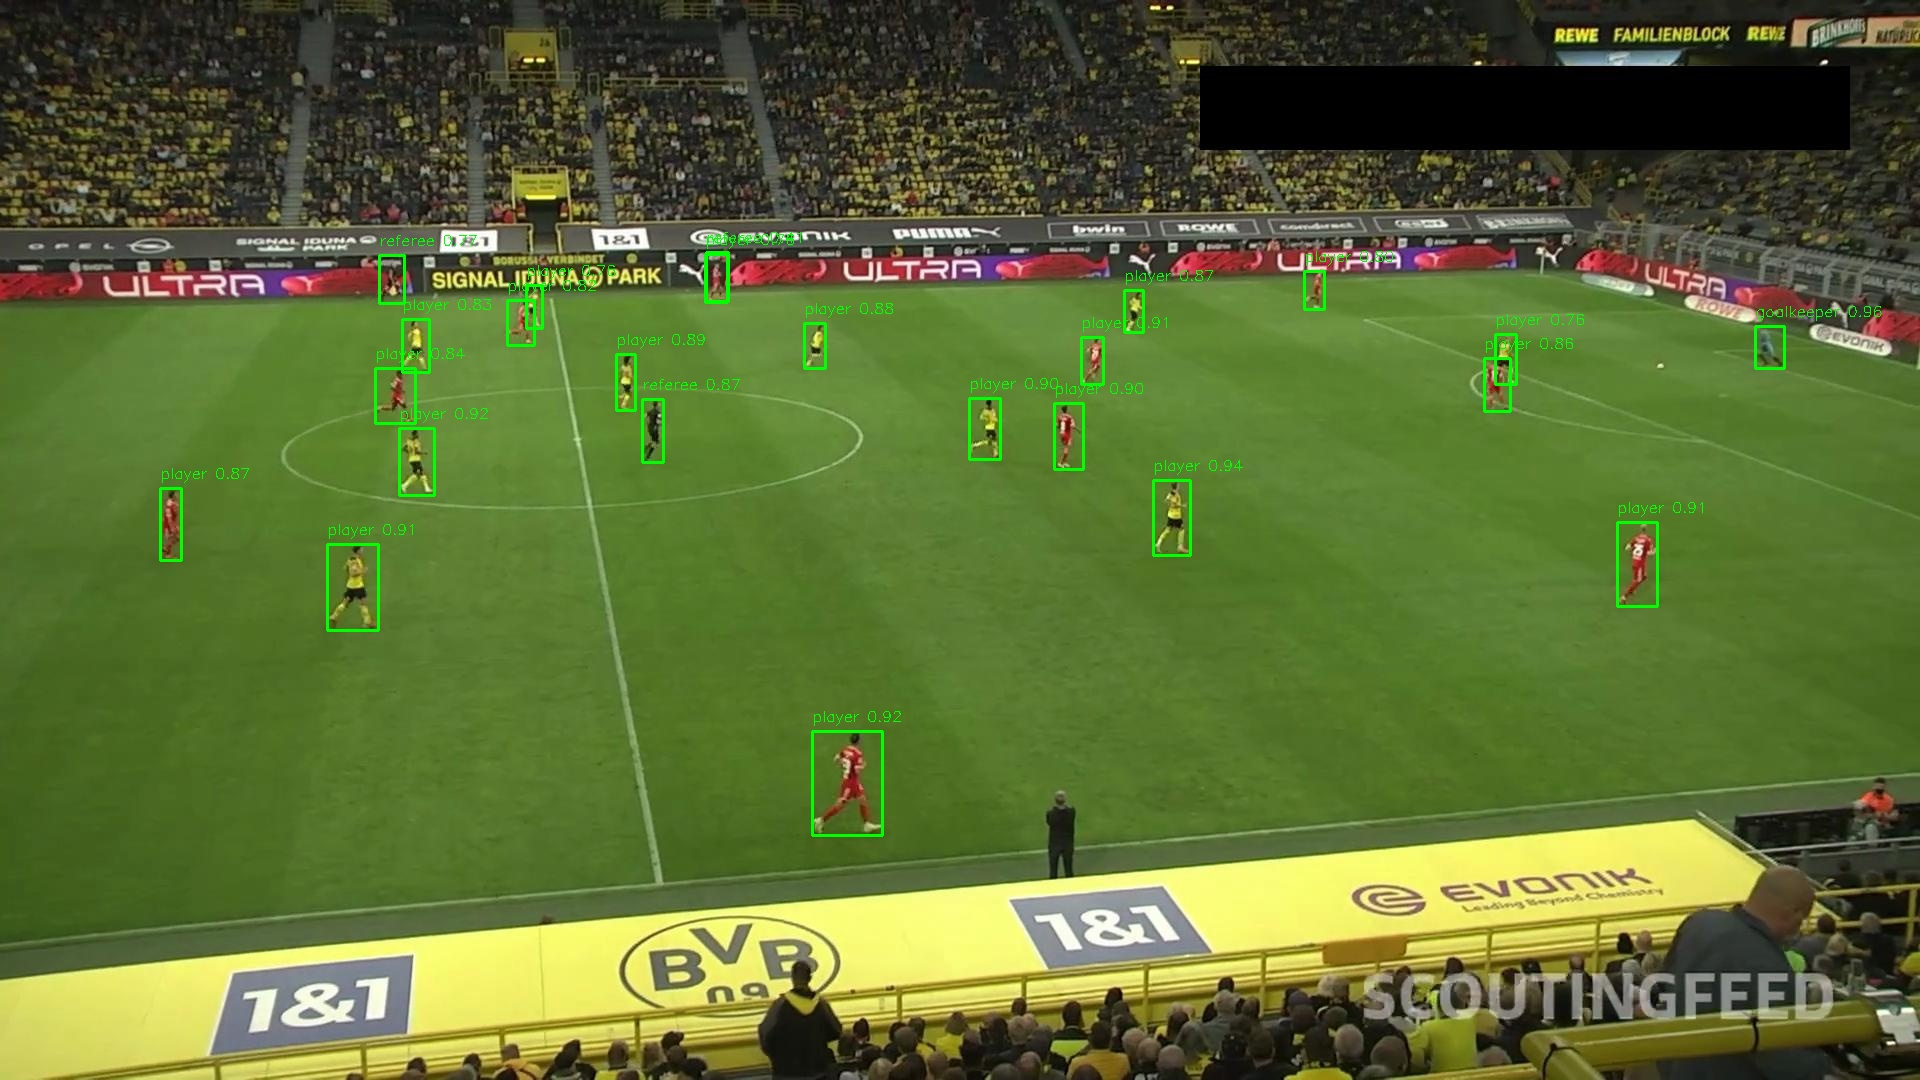

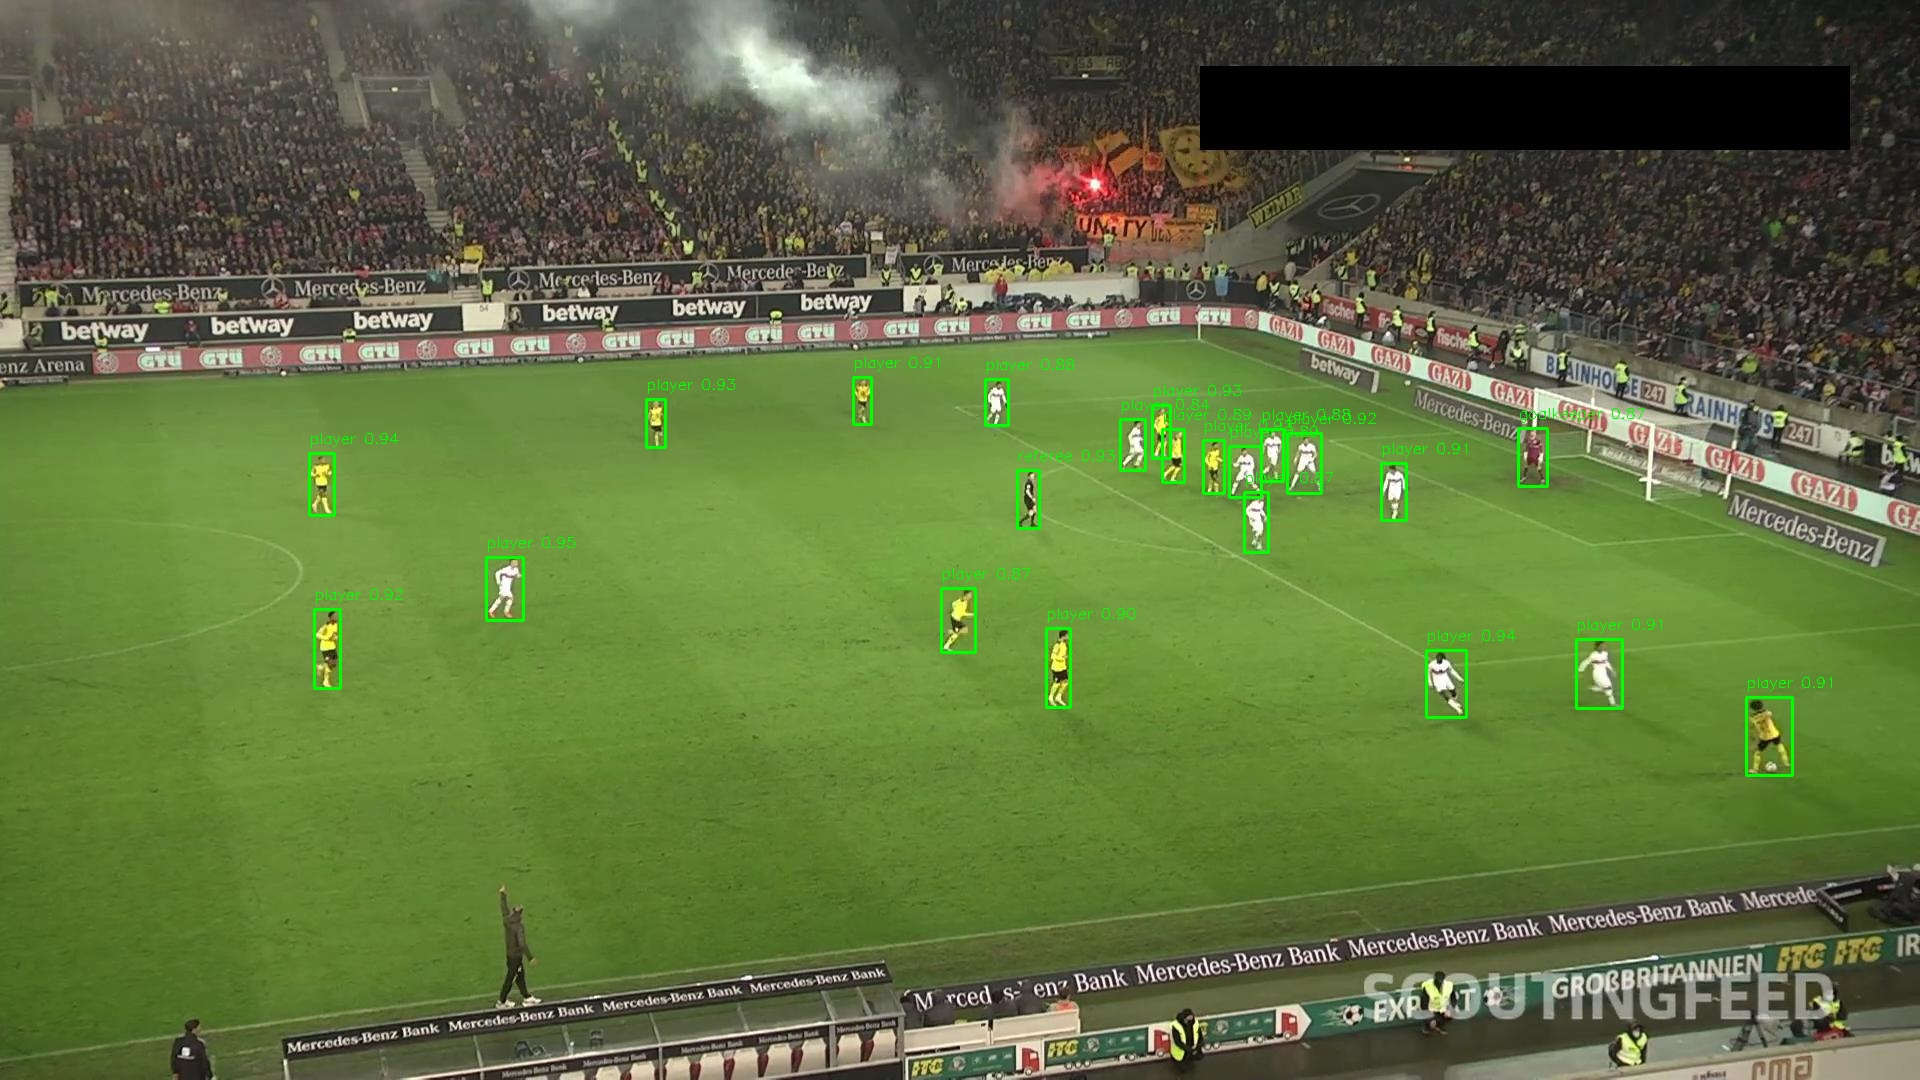

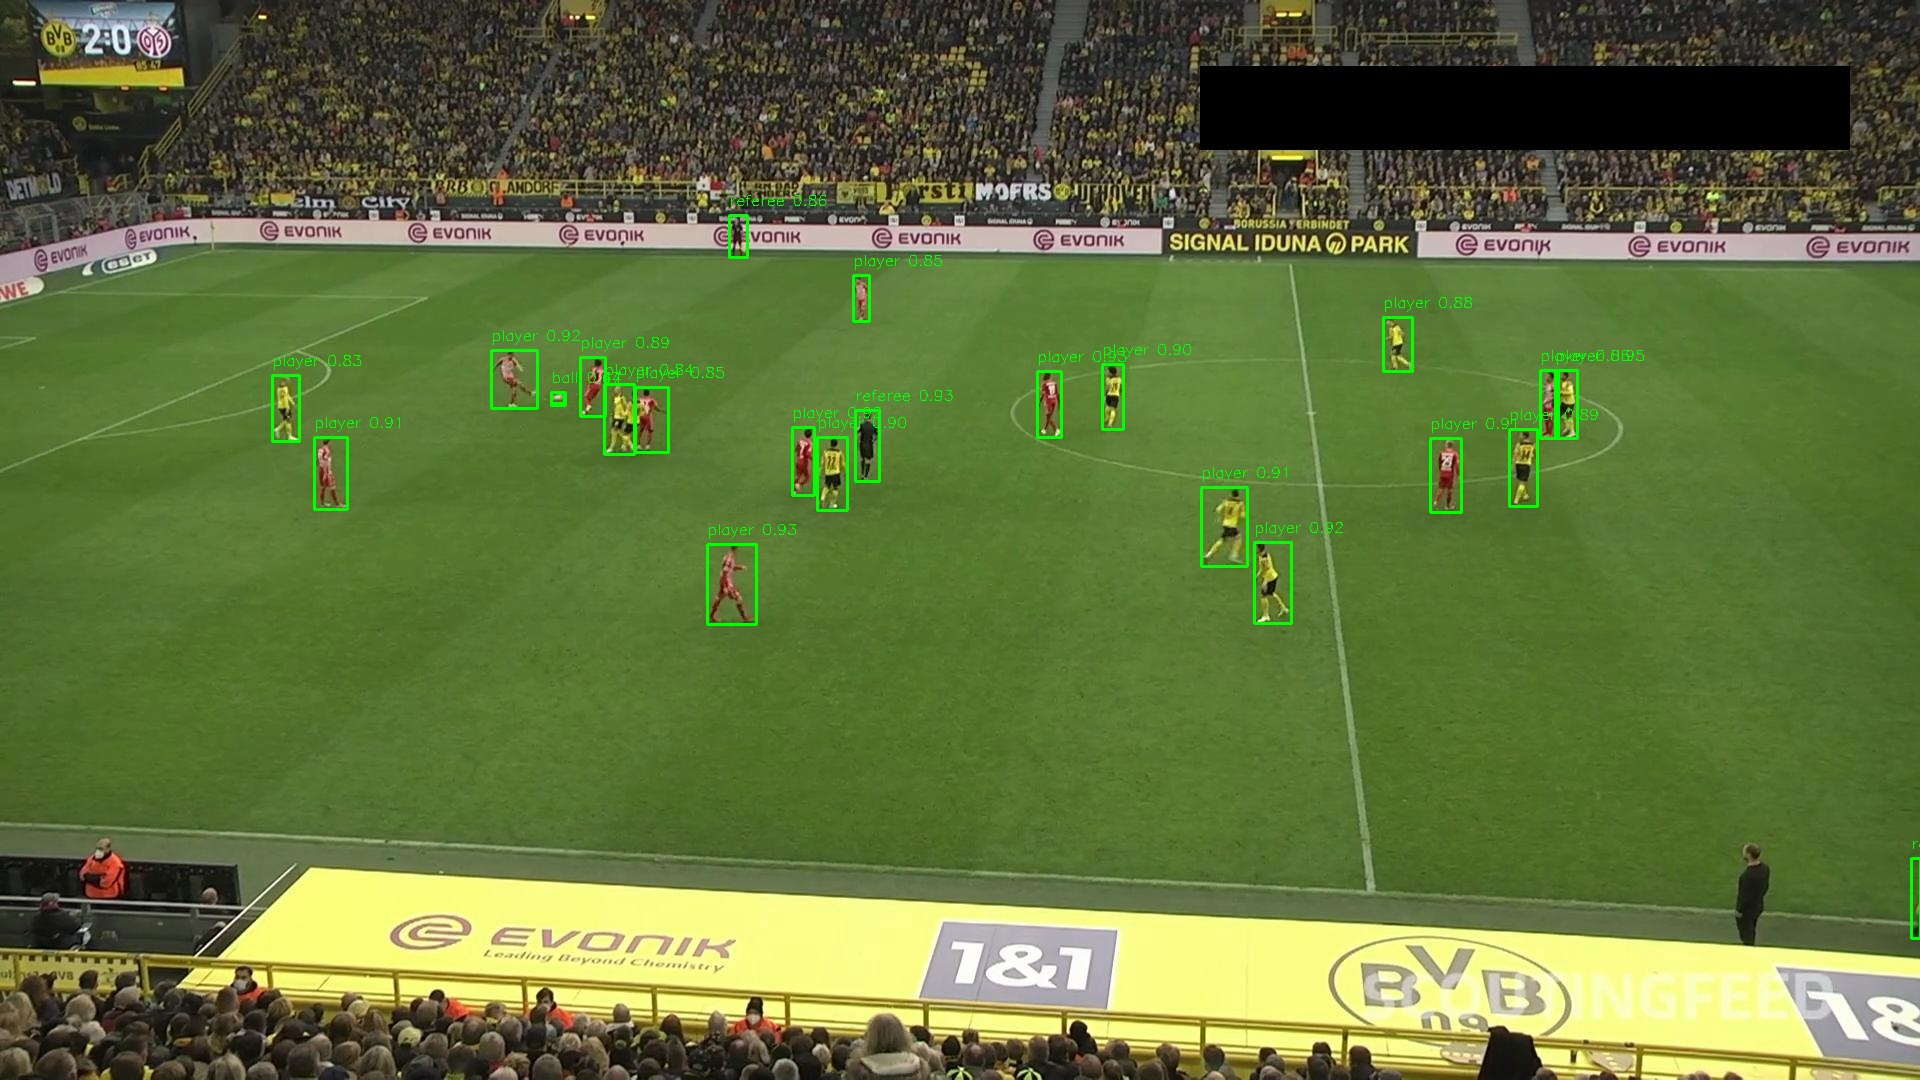

**Вывод:** Модель YOLO12 хорошо обучилась детектировать футболистов, судей и голкиперов. Но есть проблемы с детектированием у нее маленьких объектов
в частности футбольного мяча. Данные визуальный результат совпадает с результатом и по метрикам. Также у модели получились хорошие метрики по fps